<a href="https://colab.research.google.com/github/mokoshin0720/ml-tutorials/blob/main/Enc_Dec%5BTransformer%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール -> 再起動

In [1]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!pip install torchtext==0.8.0
!pip install torch==1.7.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

# 必要なモジュールのimport

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.metrics import bleu_score
from torchtext import data
from torchtext.data import Field
import MeCab

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Utils

Mecabで分かち書き

In [ ]:
def tokenizer(text):
    return m.parse(text).split()

strの文を入力して、予測結果のlistを返す

In [ ]:
def title2title(encoder, decoder, sentence, title, device, max_length):
    if type(sentence) == str:
        tokens = [token for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, title.init_token)
    tokens.append(title.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [title.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [title.vocab.stoi["<sos>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            memory = encoder(sentence_tensor) # これfor文の外でもいい気がする
            output = decoder(trg_tensor, memory)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == title.vocab.stoi["<eos>"]:
            break

    outputs_str = []
    for token_num in outputs:
        tkn = title.vocab.itos[token_num]
        outputs_str.append(tkn)

    return outputs, outputs_str[1:-1]

バッチからタイトルのリスト（文字列&数字）を返す

In [ ]:
def batch2title(batch, title, batch_size):
    sentence_list_int = []
    for size in range(batch_size):
        sentence_int = batch.title[:, size]
        sentence_list_int.append(sentence_int)

    sentence_list_str = []
    for sentence_int in sentence_list_int:
        sentence = []
        for i in sentence_int:
            s = title.vocab.itos[i]
            sentence.append(s)
        sentence.remove('<sos>')
        sentence.remove('<eos>')
        sentence = [s for s in sentence if s != '<pad>']
        # sentence = ''.join(sentence)
        sentence_list_str.append(sentence)

    return sentence_list_str, sentence_list_int

bleuスコアを計算する

In [ ]:
import nltk
nltk.download('punkt')
from nltk import bleu_score

def cal_accuracy(raw, pred):
    pred = [pred]
    score = bleu_score.sentence_bleu(pred, raw)
    return score

# データの前処理

In [121]:
m = MeCab.Tagger("-Owakati")

# Fieldオブジェクトの作成
title = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")
right = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")
left = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")

# CSVファイルを読み込み、TabularDatasetオブジェクトを作成
train_data, test_data = data.TabularDataset.splits(
    path = "/content/drive/MyDrive/data/nakazawa_lab/youtuber_title/",
    train = "youtube_train.csv",
    test = "youtube_train.csv",
    format="csv",
    fields=[('title', title), ('right', right), ('left', left)]
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [122]:
# for example in train_data[:3]:
#     print(example.title)
#     print(example.right)
#     print(example.left)
#     print("="*30)

['\ufeff', '◀', '︎', '質疑', '応答', '▶', '︎', 'ラフ', 'ァ', 'エル', 'さん', 'と', '生放送']
['ァ', 'エル', 'さん', 'と', '生放送']
['ァ', 'ラフ', '︎', '▶', '応答', '質疑', '︎', '◀']
['▶', '︎', '質疑', '応答', '◀', '︎', '苦しみ', 'の', '先', 'に', '幸せ', 'が', 'ある', '。', '苦しい', '中', 'でも', '工夫', 'を', '怠ら', 'なかっ', 'た', '場合', 'は']
['工夫', 'を', '怠ら', 'なかっ', 'た', '場合', 'は']
['工夫', 'で', 'も', '中', '苦しい', '。', 'ある', 'が', '幸せ', 'に', '先', 'の', '苦しみ', '︎', '◀', '応答', '質疑', '︎', '▶']
['▶', '︎', '質疑', '応答', '◀', '︎', 'ヒト', 'は', '神', 'を', '創っ', 'た', '、', '自分', 'の', '愚か', 'さ', 'を', '正当', '化', 'する', 'ため', 'に']
['質疑', '応答', '◀', '︎', 'ヒト', 'は', '神', 'を', '創っ', 'た', '、', '自分', 'の', '愚か', 'さ', 'を', '正当', '化', 'する', 'ため', 'に']
['質疑', '︎', '▶']


単語辞書の作成

In [123]:
title.build_vocab(train_data)
right.build_vocab(train_data)
left.build_vocab(train_data)

# Transformerモデル

Encoder -> memoryを返す

In [124]:
class Encoder(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Encoder, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
        )
        encoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoder_layers,
            norm=encoder_norm
        )

        self.device = device
        self.src_pad_idx = src_pad_idx
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src_seq_length, N = src.shape
        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        memory = self.encoder(
            src=embed_src,
            src_key_padding_mask=src_padding_mask
        )
        return memory

        def make_src_mask(self, src):
            src_mask = src.transpose(0, 1) == self.src_pad_idx
            return src_mask.to(self.device)

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

Decoder -> memoryを受け取って、生成結果を返す

In [125]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_size,
        trg_vocab_size,
        num_heads,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Decoder, self).__init__()

        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
        )
        decoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_decoder_layers,
            norm=decoder_norm
        )

        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)

        self.device = device
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, memory):
        trg_seq_length, N = trg.shape
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )
        trg_mask = self.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        out = self.decoder(
            tgt=embed_trg,
            memory=memory,
            tgt_mask=trg_mask,
        )

        out = self.fc_out(out)
        return out

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# ハイパーパラメータ

In [126]:
num_epochs = 50
learning_rate = 3e-4
batch_size = 32

In [127]:
src_vocab_size = len(title.vocab)
trg_vocab_size = len(title.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.10
max_len = 50
forward_expansion = 4
src_pad_idx = 0

# 学習

In [ ]:
train_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size=batch_size,
        sort_within_batch=True,
        sort_key=lambda x: len(x.title),
        device=device,
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


モデルの宣言

In [ ]:
encoder = Encoder(
    embedding_size,
    src_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder_left = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder_right = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

optimizerとloss関数の宣言

In [ ]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_left_optimizer = optim.Adam(decoder_left.parameters(), lr=learning_rate)
decoder_right_optimizer = optim.Adam(decoder_right.parameters(), lr=learning_rate)

encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_left_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_left_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_right_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_right_optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

学習開始(Encoder-Decoderモデル)

In [ ]:
mean_losses_left = []
mean_losses_right = []
losses = []

for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")
    losses_left = []
    losses_right = []

    for batch_idx, batch in enumerate(train_iterator):
        '''
        入力データ
        '''
        inp_data = batch.title.to(device)
        target_left = batch.left.to(device)
        target_right = batch.right.to(device)

        '''
        encoderとdecoderに渡す
        '''
        memory = encoder(inp_data)
        output_left = decoder_left(target_left[:-1, :], memory)
        output_right = decoder_right(target_right[:-1, :], memory)

        '''
        outputの形式を変更
        '''
        output_left = output_left.reshape(-1, output_left.shape[2])
        target_left = target_left[1:].reshape(-1)
        output_right = output_right.reshape(-1, output_right.shape[2])
        target_right = target_right[1:].reshape(-1)

        '''
        勾配の初期化
        '''
        encoder_optimizer.zero_grad()
        decoder_left_optimizer.zero_grad()
        decoder_right_optimizer.zero_grad()

        '''
        loss計算
        '''
        loss_left = criterion(output_left, target_left)
        loss_right = criterion(output_right, target_right)
        losses_left.append(loss_left.item())
        losses_right.append(loss_right.item())

        '''
        誤差逆伝搬
        '''
        loss_left.backward(retain_graph=True)
        loss_right.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder_left.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder_right.parameters(), max_norm=1)

        '''
        重みの更新
        '''
        encoder_optimizer.step()
        decoder_left_optimizer.step()
        decoder_right_optimizer.step()

    '''
    バッチの平均ロスを計算
    '''
    mean_loss_left = sum(losses_left) / len(losses_left)
    mean_loss_right = sum(losses_right) / len(losses_right)

    '''
    スケジューラー（学習率の調整）
    '''
    decoder_left_scheduler.step(mean_loss_left)
    decoder_right_scheduler.step(mean_loss_right)
    '''
    loss append
    '''
    mean_losses_left.append(mean_loss_left)
    mean_losses_right.append(mean_loss_right)
    print("left: ", mean_loss_left)
    print("right: ", mean_loss_right)

損失関数の可視化

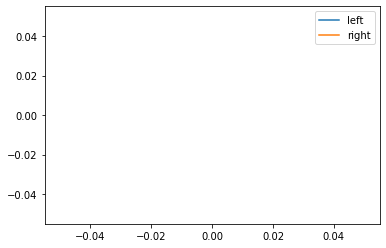

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(mean_losses_left, label='left')
plt.plot(mean_losses_right, label='right')
plt.legend()

# 予測

In [ ]:
def translate_sentence(encoder, decoder_left, decoder_right, sentence, title, device, max_length=50):
    if type(sentence) == str:
        tokens = [token for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, title.init_token)
    tokens.append(title.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [title.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs_left = [title.vocab.stoi["<sos>"]]
    outputs_right = [title.vocab.stoi["<sos>"]]

    for i in range(max_length):
        trg_tensor_left = torch.LongTensor(outputs_left).unsqueeze(1).to(device)
        trg_tensor_right = torch.LongTensor(outputs_right).unsqueeze(1).to(device)

        with torch.no_grad():
            memory = encoder(sentence_tensor) # これfor文の外でもいい気がする
            output_left = decoder_left(trg_tensor_left, memory)
            output_right = decoder_right(trg_tensor_right, memory)

        best_guess_left = output_left.argmax(2)[-1, :].item()
        best_guess_right = output_right.argmax(2)[-1, :].item()
        outputs_left.append(best_guess_left)
        outputs_right.append(best_guess_right)

        if best_guess_right == title.vocab.stoi["<eos>"]:
            break

    translated_sentence_right = [title.vocab.itos[idx] for idx in outputs_right]
    translated_sentence_left = [title.vocab.itos[idx] for idx in outputs_left]
    # remove start token
    return translated_sentence_left[1:], translated_sentence_right[1:]

In [ ]:
sentence = "▶︎質疑応答◀︎ヒトは神を創った、自分の愚かさを正当化するために"

In [ ]:
translated_sentence = translate_sentence(
        encoder, decoder_left, decoder_right, sentence, title, device, max_length=50
    )
print(f"Translated example sentence: \n {translated_sentence}")

# Decoderだけの場合

データ定義

In [144]:
train_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size=batch_size,
        sort_within_batch=True,
        sort_key=lambda x: len(x.title),
        device=device,
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


モデル定義

In [145]:
encoder = Encoder(
    embedding_size,
    src_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

optim定義

In [146]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_optimizer, factor=0.1, patience=10, verbose=True
)
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

学習

In [152]:
mean_losses = []
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")
    losses = []
    output2bests = []

    encoder.train()
    decoder.train()

    for batch_idx, batch in enumerate(train_iterator):
        '''
        入力データ
        '''
        inp_data = batch.title.to(device)
        target = batch.title.to(device)

        '''
        encoderとdecoderに渡す
        '''
        memory = encoder(inp_data)
        output = decoder(target[:-1, :], memory)

        '''
        勾配の初期化
        '''
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        '''
        loss計算
        '''
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        loss = criterion(output, target)
        losses.append(loss.item())

        '''
        誤差逆伝搬
        '''
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

        '''
        重みの更新
        '''
        encoder_optimizer.step()
        decoder_optimizer.step()

        '''
        予測
        '''
        if batch_idx != 0: continue
        encoder.eval()
        decoder.eval()
        sentence_list_str, sentence_list_int = batch2title(batch, title, batch_size)
        batch_score = 0
        for sentence_str, sentence_int in zip(sentence_list_str, sentence_list_int):
            pred_num, pred_str = title2title(encoder, decoder, sentence_str, title, device, max_len)
            score = cal_accuracy(sentence_str, pred_str)
            batch_score += score
        print(sentence_str)
        print(pred_str)
        print("正解率： ", batch_score / batch_size)

    '''
    バッチの平均ロスを計算
    '''
    mean_loss = sum(losses) / len(losses)

    '''
    スケジューラー（学習率の調整）
    '''
    decoder_scheduler.step(mean_loss)
    '''
    loss append
    '''
    mean_losses.append(mean_loss)
    print("loss: ", mean_loss)

[Epoch 0 / 50]


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


['【', 'GACKT×', '中田', '敦彦', '】', '海外', '移住', '・', '生き方', '・', 'ビジネス', '・', 'ボランティア', 'を', '語る']
['【', 'GACKT×', '敦彦', '敦彦', '海外', '海外', '海外', '・', '生き方', '・', 'ビジネス', '・', 'ボランティア', 'を', 'を', '語る']
正解率：  0.6473788017037222
loss:  1.139825604737751
[Epoch 1 / 50]
['Vlog', '【', 'フィルム', 'カメラ', 'で', 'あそぼ', 'う', '！', '！】～', 'ニコン', 'FE', '～']
['【', 'フィルム', 'フィルム', 'カメラ', 'で', 'あそぼ', 'う', '！', '！】～', 'ニコン', '～', '～']
正解率：  0.7166896768115434
loss:  1.3592447146536812
[Epoch 2 / 50]
['1', '億', '円', '寄付', 'し', 'て', 'コロナ', '医療', '支援', '募金', 'を', '立ち', '上げ', 'まし', 'た', '。', '僕', 'と', '一緒', 'に', '募金', 'し', 'て', '命', 'を', '守る', '人', 'を', '支え', 'ませ', 'ん', 'か', '？']
['1', '億', '円', '寄付', 'し', 'て', 'コロナ', 'コロナ', '支援', '支援', '支援', '支援', '支援', '支援', '支援', '支援', '支援', '支援', '支援', '募金', 'と', '募金', '募金', 'と', '一緒', 'と', 'ませ', 'と', 'ませ', 'ん', 'ん', 'ん', 'ん', 'ませ', 'ん', 'ん']
正解率：  0.19185659814143927
loss:  4.450397090306358
[Epoch 3 / 50]


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


['【', 'ボタン', '式', '/', 'Bluetooth', '搭載', 'の', 'MP', '3', 'プレーヤー', '】', '音質', '良し', '、', '画面', '良し', '、', '使い', 'やす', 'さ', '良し', '、', '機能', '良し', '！', '！']
['良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し', '良し']
正解率：  0.19671135341159457
loss:  3.84639545092507
[Epoch 4 / 50]
['【', 'コンビニ', '新', '商品', '】', 'JUICY', 'DROP', 'GUMMIES', '！', 'レビュー', '！', 'ジューシードロップグミ', 'Japanese', 'Sweets', 'Review', '【', 'セブン', '】', '【#', '49', '】']
['！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！', '！']
正解率：  0.13478710382277284
loss:  3.6983810757833813
[Epoch 5 / 50]


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


['【', '万', '乳', '引力', '】', '男', 'は', 'なぜ', '【', '巨乳', 'に', '惹か', 'れる', 'の', 'か', '】']
['【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【', '【']
正解率：  0.11877659468292077
loss:  3.598333169543554
[Epoch 6 / 50]
['幸せ', 'な', '結婚', 'の', '【', '絶対', '条件', '】', 'が', '判明', '【', 'カリフォルニア', '大学', '最新', '研究', '】']
['判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明', '判明']
正解率：  0.1083322774196349
loss:  3.2168736552435253
[Epoch 7 / 50]
['何', 'を', 'やっ', 'て', 'も', '【', '続か', 'ない', '人', '】', 'の', '問題', '点', 'TOP', '5']
['も', 'も', 'も', 'も', 'も', 'も', 'も', 'も', 'も', 'も', 'も', 'も', 'も'